# Implementando modelos de Machine Learning do zero

<br>
<br>

Até então, estivemos utilizando os modelos de machine learning diretamente das bibliotecas do scikit-learn, sem ter muito conhecimento de como exatamente os modelos funcionam.

Neste módulo, pretendemos discutir os modelos __regressão linear e regressão logística__ em detalhe. Queremos explicar o funcionamento desses modelos e implementá-los do zero. Desta forma, conseguiremos entender ainda mais o significado de "aprendizado" de um modelo.

Além disso, também discutiremos os temas de __regressão polinomial__ e __regularização Ridge e Lasso.__

<br>
<br>


## Regressão Linear

<br>

Assumindo que temos um dataset com p variáveis preditoras $X_1, .., X_p$, N instâcias de treinamento e uma variável target y (numérica), o modelo de regressão linear estima:

#### $y_{pred} = \theta_0 + \theta_1 \cdot X_1 + .. + \theta_p \cdot X_p$.

Onde os valores de $\theta = (\theta_0, \theta_1, .., \theta_p)$ são aqueles que minimizam o MSE no dataset de treinamento:

$MSE(\theta) = $ 1/N $\cdot \sum (y_{pred_i} - y_i)^{2}$, em que a soma é nas instâncias de treinamento.


<br>
<br>

__Como podemos resolver esse problema de otimização?__


Existem duas abordagens no caso da regressão linear.

1- Usar uma fórmula fechada; conhecida como __equação normal__

2- Usar algoritmos iterativos - __gradient descent__ - que vão atualizando os valores de $\theta$ até convergirem para uma resposta ótima.


Vamos discutir as duas soluções abaixo.

<br>

### Equação normal

No caso da regressão linear, existe uma solução fechada para achar os valores ótimos de $\theta$!

Considere que o dataset de treinamento seja da forma (X, y), em que X - variáveis explicativas - é um array de dimensão (N, p) e y é a variável target.

$\hat \theta = (X^{T} \cdot X)^{-1} \cdot X^{T} \cdot y$

Ou seja, matematicamente:

Calculamos a __transposta__ da matriz X, $X^{T}$ e também a __inversa__ do produto entre a transposta e a matriz.
Na sequência, multiplicamos essa inversa pela transposta de X e por y.

__Obs.:__ Para podermos estimar o parâmetro $\theta_0$, devemos incluir uma coluna a mais em nosso conjunto de variáveis. Essa coluna recebe o valor 1 em todas as entradas. Dessa forma, denotando por $X_0$ essa coluna, e considerando $X = [X_0 X_1 ... X_p],$ calculamos o valor $\hat \theta$ de acordo com a fórmula acima. 

__Importante:__ não é necessário entender como chegamos nesse valor - isso envolve alguns cálculos matemáticos - mas devemos nos atentar a como __os valores de X e y__ fazem parte da solução! Isso mostra como é fundamental o __dataset de treinamento na hora de treinar os modelos!__


Vamos implementar a equação normal em python:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

Para fins de simulação, vamos criar uma relação entre X e y da forma:
    
### $y = 4 + 3 \cdot X + $ erro aleatório,

ou seja, a relação entre X e y é de fato linear e os parâmetros ótimos são:

### $\theta_{0_{otimo}} = 4$

### $\theta_{1_{otimo}} = 3$

In [2]:
#função para gerar uma massa de dados

def geraDados1(tamanho_amostra):
    X = 2 * np.random.rand(tamanho_amostra, 1)
    y = 4 + 3 * X + np.random.randn(tamanho_amostra, 1)
    return X, y

In [3]:
#Neste caso, temos apenas 1 variável explicativa

X, y = geraDados1(500)
X.shape, y.shape

((500, 1), (500, 1))

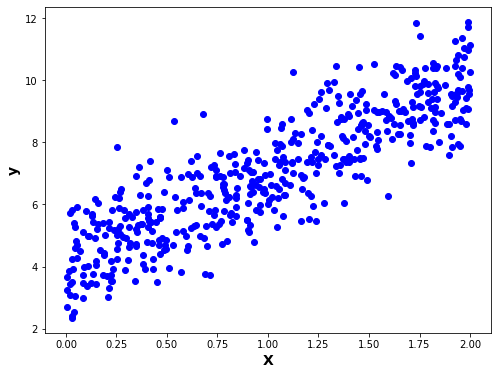

In [4]:
plt.figure(figsize=[8,6])
plt.scatter(X, y, c = 'blue')
plt.xlabel("X", fontsize = 14, fontweight = 'bold')
plt.ylabel("y", fontsize = 14, fontweight = 'bold')
plt.show()

<br>

__Equação normal:__
    
$\hat \theta = (X^{T} \cdot X)^{-1} \cdot X^{T} \cdot y$

<br>

In [5]:
def regLinearEquacaoNormal(X, y):
    # adicionando x0 = 1 em cada instância
    X = np.c_[np.ones((X.shape[0], 1)), X]
    
    transposta_X = X.T
    XTX = transposta_X.dot(X)
    inversa = np.linalg.inv( XTX )
    
    theta_best = inversa.dot(transposta_X).dot(y)
    return theta_best

In [6]:
regLinearEquacaoNormal(X, y)

array([[4.0684615 ],
       [2.94777099]])

Veja que tivemos bons resultados! Os valores retornados são próximos dos valores ótimos!

Naturalmente, não conseguimos chegar nos valores cravados devido aos erros aleatórios.

Vamos comparar com os resultados obtidos pela implementação do scikit-learn: 

In [7]:
from sklearn.linear_model import LinearRegression

In [8]:
lm = LinearRegression()
lm.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [9]:
lm.intercept_, lm.coef_

(array([4.0684615]), array([[2.94777099]]))

É o mesmo resultado!

Dessa forma, já temos uma clareza maior em como a regressão linear funciona!

Mas existem algumas __complicações__ com a equação normal:

1- __Complexidade computacional:__ Calcular a equação normal é bastante custoso, computacionalmente falando. Especialmente quando a quantidade de variáveis explicativas é grande.

2- Para a __regressão logística (e outros modelos, como Redes Neurais)__, não existe fórmula fechada como a equação normal.

Diante disto, vamos rever um jeito de estimar os parâmetros da regressão linear, usando um algoritmo iterativo conhecido como __gradiente descente__. 

#### Atenção: Modelos de Redes Neurais - que estão dentre os algoritmos mais avançados em Machine Learning - usam metodologias similares ao gradient descent, então muita atenção a esta parte do conteúdo!

<br>


### Gradient Descent

<br>

Para motivar a técnica, considere o problema:

#### Defina uma função $f(x) = x^2$. Pergunta: Qual o valor de x que minimiza f?

Para este caso, é fácil ver que quando x = 0, f(x) = f(0) = $0^2$ = 0. Além disso, como $x^2$ é sempre positivo, qualquer outro valor de x irá resultar em f(x) positivo, de modo que x = 0 é o valor que minimiza f.

Podemos ver isso graficamente:

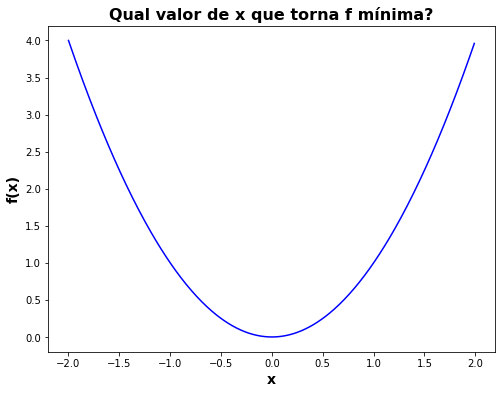

In [10]:
def f(x):
    return x**2

xlims = np.arange(-2,2, 0.01)
fxlims = [f(x) for x in xlims]
plt.figure(figsize=[8,6])
plt.title("Qual valor de x que torna f mínima?", fontsize = 16, fontweight = 'bold')
plt.plot(xlims, fxlims, c = 'blue')
plt.xlabel("x", fontsize = 14, fontweight = 'bold')
plt.ylabel("f(x)", fontsize = 14, fontweight = 'bold')
plt.show()

Para resolver esse problema, vamos fazer uma analogia:
    
Suponha que você esteja perdido em uma montanha e o clima está bem ruim, com muita neblina. Desta forma, vc não consegue ver quase nada a sua frente. Como o seu objetivo é sair da montanha, o que você faz?

Como a visão mais ampla está prejudicada, uma ideia é dar pequenos passos na direção em que você sente que a montanha está mais inclinada para baixo. Desta forma, repetindo essa lógica, vc terá uma chance de sair da montanha!

Essa é a lógica que o __gradiente descente__ usa: iterativamente, o algoritmo calcula o gradiente (ou derivada) da função que estamos querendo minimizar e vai na direção oposta:

__O algoritmo pode ser reduzido aos seguintes passos:__

1 - seleciona um valor aleatório de x - chamado x0;

2 - calcula o gradiente (ou derivada) da função neste ponto: grad_f(x0);

3 - atualiza o valor de x0 para x1 conforme a regra: x1 = x0 - $\alpha$ * grad_f(x0)

4 - Loop nos passos 2 e 3 até atingir um critério de parada

5 - O valor final de x - após as iterações acima - é a resposta, de acordo com o algoritmo.

Um ponto de atenção: Nos passos acima, inserimos um parâmetro $\alpha$, também conhecido como __taxa de aprendizagem__ (ou learning rate ou learning step, em inglês). Esse parâmetro é o que caracteriza o "tamanho dos passos", de acordo com o exemplo da montanha.

Vamos implementar o algoritmo para resolver o problema para f(x) = $x^2$.

In [11]:
learning_rate = 0.25

num_steps = 10

initial_x = 1.789 #um valor aleatório qualquer

def gradiente_f(x): #essa função depende da função f, descrita acima!
    return 2*x #valor da derivada da função f(x) = xˆ2

x_final = None
for step in range(num_steps):
    if step == 0:
        x_final = initial_x
    else:
        x_final = x_final - learning_rate * gradiente_f(x_final)
    print("Step ", step, " | x: ", x_final, " | f(x): ", f(x_final))

Step  0  | x:  1.789  | f(x):  3.2005209999999997
Step  1  | x:  0.8945  | f(x):  0.8001302499999999
Step  2  | x:  0.44725  | f(x):  0.20003256249999998
Step  3  | x:  0.223625  | f(x):  0.050008140624999996
Step  4  | x:  0.1118125  | f(x):  0.012502035156249999
Step  5  | x:  0.05590625  | f(x):  0.0031255087890624997
Step  6  | x:  0.027953125  | f(x):  0.0007813771972656249
Step  7  | x:  0.0139765625  | f(x):  0.00019534429931640623
Step  8  | x:  0.00698828125  | f(x):  4.883607482910156e-05
Step  9  | x:  0.003494140625  | f(x):  1.220901870727539e-05


In [12]:
1.220901870727539e-05 < 0.0001

True

Veja que após 10 passos (steps), o valor de x já é muito próximo de 0!

Alguns pontos de atenção:

1 - Se a learning_rate for muito baixa, o algoritmo pode demorar muito para "convergir".

2 - Se a learning_rate for muito grande, o algoritmo pode "divergir" e não chegar em resultados satisfatórios.

Vejamos os exemplos:

In [13]:
learning_rate = 0.01

num_steps = 200

initial_x = 1.789 #um valor aleatório qualquer

def gradiente_f(x): 
    return 2*x 

x_final = None
for step in range(num_steps):
    if step == 0:
        x_final = initial_x
    else:
        x_final = x_final - learning_rate * gradiente_f(x_final)
    print("Step ", step, " | x: ", x_final, " | f(x): ", f(x_final))

Step  0  | x:  1.789  | f(x):  3.2005209999999997
Step  1  | x:  1.75322  | f(x):  3.0737803684
Step  2  | x:  1.7181556  | f(x):  2.95205866581136
Step  3  | x:  1.683792488  | f(x):  2.83515714264523
Step  4  | x:  1.6501166382399999  | f(x):  2.7228849197964786
Step  5  | x:  1.6171143054752  | f(x):  2.6150586769725384
Step  6  | x:  1.584772019365696  | f(x):  2.511502353364426
Step  7  | x:  1.553076578978382  | f(x):  2.4120468601711944
Step  8  | x:  1.5220150473988143  | f(x):  2.316529804508415
Step  9  | x:  1.491574746450838  | f(x):  2.2247952242498816
Step  10  | x:  1.4617432515218212  | f(x):  2.1366933333695863
Step  11  | x:  1.4325083864913848  | f(x):  2.052080277368151
Step  12  | x:  1.4038582187615571  | f(x):  1.970817898384372
Step  13  | x:  1.375781054386326  | f(x):  1.892773509608351
Step  14  | x:  1.3482654332985995  | f(x):  1.8178196786278602
Step  15  | x:  1.3213001246326275  | f(x):  1.7458340193541968
Step  16  | x:  1.2948741221399749  | f(x):  1.6

Veja que neste caso o valor de x após 10 passos ainda é muito grande... então precisaríamos de muitas iterações para resolver o problema.

In [14]:
learning_rate = 2

num_steps = 10

initial_x = 1.789 #um valor aleatório qualquer

def gradiente_f(x): #essa função depende da função f, descrita acima!
    return 2*x #valor da derivada da função f(x) = xˆ2

x_final = None
for step in range(num_steps):
    if step == 0:
        x_final = initial_x
    else:
        x_final = x_final - learning_rate * gradiente_f(x_final)
    print("Step ", step, " | x: ", x_final, " | f(x): ", f(x_final))

Step  0  | x:  1.789  | f(x):  3.2005209999999997
Step  1  | x:  -5.367  | f(x):  28.804689
Step  2  | x:  16.101  | f(x):  259.24220099999997
Step  3  | x:  -48.303  | f(x):  2333.1798089999998
Step  4  | x:  144.909  | f(x):  20998.618281
Step  5  | x:  -434.727  | f(x):  188987.56452899997
Step  6  | x:  1304.181  | f(x):  1700888.080761
Step  7  | x:  -3912.543  | f(x):  15307992.726849
Step  8  | x:  11737.629  | f(x):  137771934.54164103
Step  9  | x:  -35212.887  | f(x):  1239947410.8747692


Veja que, neste caso, a learning_rate é muito grande, de modo que o algoritmo diverge!

<br>

Agora que entendemos a motivação por trás do gradiente descente, __vamos usá-lo no contexto da regressão linear.__

<br><br><br>

Como já vimos, a regressão linear busca encontrar os valores de $\theta$ que minimizem o MSE. Neste caso, nossa __função objetivo a ser minimizada será o MSE__.

Abaixo, seguem as fórmulas para o cáculo do gradiente descente:

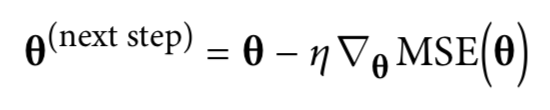

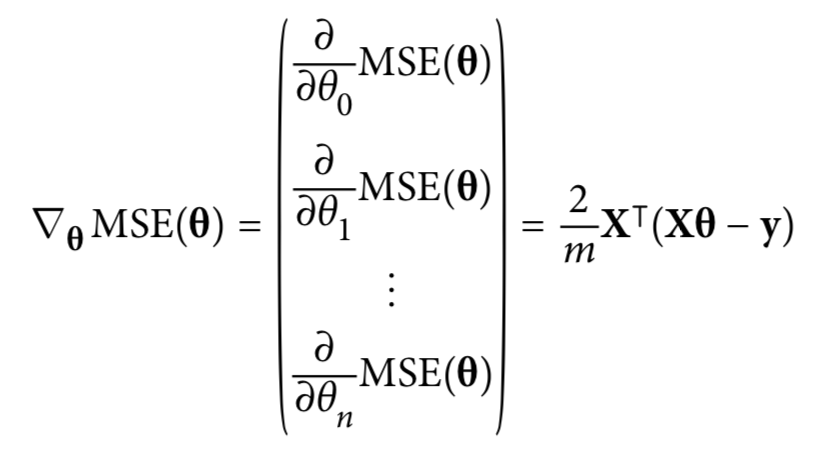

Nas figuras, $\eta$ é a learning_rate; X é o dataset de treinamento e y é nossa variável target. Ainda, m é a quantidade de linhas no dataset de treinamento.

Voltando para nosso problema...

In [15]:
X.shape, y.shape

((500, 1), (500, 1))

In [16]:
from sklearn.metrics import mean_squared_error

def MSE(ytrue, ypred):
    return mean_squared_error(y_true = ytrue, y_pred = ypred)

In [17]:
learning_rate = 0.075
num_steps = 200

m = X.shape[0] #qtd. linhas
k = X.shape[1] #qtd. colunas

theta = np.random.randn(k+1,1) # inicialização aleatórias dos parâmetros.
X_b = np.c_[np.ones((m, 1)), X] #colocando x0 = 1 em todas as instâncias de X

for step in range(num_steps):
    
    print('passo:', step)
    print('theta:', theta.reshape(-1,))
    
    #calcula o gradiente
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    
    #atualiza os valores de theta
    theta = theta - learning_rate * gradients
    
    
    #calculando o MSE dentro do passo:
    ypred_step = X_b.dot(theta)
    MSE_step = MSE(ytrue = y, ypred = ypred_step)
    print("MSE:", MSE_step)
    print('\n-----------------------------------------------------------\n') 

passo: 0
theta: [-1.11112244 -0.60448063]
MSE: 37.482668684590166

-----------------------------------------------------------

passo: 1
theta: [0.20344892 0.91300512]
MSE: 17.483904861900683

-----------------------------------------------------------

passo: 2
theta: [1.09116291 1.91816308]
MSE: 8.55475489670701

-----------------------------------------------------------

passo: 3
theta: [1.69358899 2.58139603]
MSE: 4.562458414971217

-----------------------------------------------------------

passo: 4
theta: [2.10527077 3.01649129]
MSE: 2.7721791958480595

-----------------------------------------------------------

passo: 5
theta: [2.38934856 3.29942944]
MSE: 1.9643346441850662

-----------------------------------------------------------

passo: 6
theta: [2.58799194 3.48094446]
MSE: 1.5950475478629715

-----------------------------------------------------------

passo: 7
theta: [2.7293665  3.59491115]
MSE: 1.4217622984471023

------------------------------------------------------

MSE: 0.9878941864710228

-----------------------------------------------------------

passo: 72
theta: [3.84385191 3.13433305]
MSE: 0.9872317809393942

-----------------------------------------------------------

passo: 73
theta: [3.84930715 3.12980188]
MSE: 0.9866011612563893

-----------------------------------------------------------

passo: 74
theta: [3.85462991 3.12538078]
MSE: 0.9860008021627454

-----------------------------------------------------------

passo: 75
theta: [3.85982338 3.12106704]
MSE: 0.9854292515895007

-----------------------------------------------------------

passo: 76
theta: [3.86489072 3.11685808]
MSE: 0.9848851271459218

-----------------------------------------------------------

passo: 77
theta: [3.86983498 3.11275135]
MSE: 0.9843671127759612

-----------------------------------------------------------

passo: 78
theta: [3.87465916 3.10874436]
MSE: 0.9838739555751549

-----------------------------------------------------------

passo: 79
theta: [3.87936

theta: [4.03780709 2.97323273]
MSE: 0.9743346821741415

-----------------------------------------------------------

passo: 154
theta: [4.03855162 2.97261432]
MSE: 0.9743229359900158

-----------------------------------------------------------

passo: 155
theta: [4.03927806 2.97201093]
MSE: 0.9743117534521952

-----------------------------------------------------------

passo: 156
theta: [4.03998686 2.9714222 ]
MSE: 0.9743011075138406

-----------------------------------------------------------

passo: 157
theta: [4.04067844 2.97084777]
MSE: 0.974290972425968

-----------------------------------------------------------

passo: 158
theta: [4.04135323 2.97028729]
MSE: 0.9742813236751704

-----------------------------------------------------------

passo: 159
theta: [4.04201163 2.96974042]
MSE: 0.9742721379243292

-----------------------------------------------------------

passo: 160
theta: [4.04265403 2.96920683]
MSE: 0.9742633929561686

-------------------------------------------------

In [18]:
regLinearEquacaoNormal(X, y)

array([[4.0684615 ],
       [2.94777099]])

Veja que os resultados são muito bons! 

Vamos na sequência implementar uma classe python para usarmos o gradient descent em problemas reais:

In [19]:
class regLinear():
    
    def __init__(self, learning_rate, num_steps):
        self.learning_rate = learning_rate
        self.num_steps = num_steps
        
    def fit(self, X, y):
        y = y.reshape(-1,1)
        m = X.shape[0] 
        k = X.shape[1] 
        theta = np.random.randn(k+1,1) 
        X_b = np.c_[np.ones((m, 1)), X] 
        for step in range(self.num_steps):
            gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
            theta = theta - self.learning_rate * gradients
        self.theta_final = theta
        print("modelo treinado.")
        
    def predict(self, X):
        m = X.shape[0]
        X_b = np.c_[np.ones((m, 1)), X]
        preds = X_b.dot(self.theta_final)
        return preds

In [20]:
rg = regLinear(learning_rate = 0.075, num_steps = 200)

In [21]:
rg.fit(X, y)

modelo treinado.


In [22]:
rg.theta_final

array([[4.04355267],
       [2.96846042]])

In [23]:
rg.predict(X)

array([[7.25891359],
       [4.29651861],
       [4.62226389],
       [8.34051881],
       [7.07681957],
       [8.7491519 ],
       [4.53999521],
       [9.25669388],
       [9.46544666],
       [5.09269407],
       [8.89164881],
       [6.83332369],
       [8.11993186],
       [8.08650808],
       [6.36693267],
       [8.77517537],
       [6.2178663 ],
       [9.24045555],
       [9.13651792],
       [4.05386021],
       [5.31772175],
       [7.73640922],
       [7.1974994 ],
       [4.72169264],
       [6.74890667],
       [4.1832323 ],
       [7.10691682],
       [8.39945102],
       [4.71037755],
       [5.24614176],
       [5.47943491],
       [9.36262366],
       [4.66567062],
       [6.19540196],
       [9.47302406],
       [7.70236047],
       [5.29949841],
       [4.31426735],
       [5.07932799],
       [6.88385871],
       [7.74619489],
       [6.13049569],
       [9.7954655 ],
       [9.97568184],
       [4.10199531],
       [8.46874753],
       [5.76827092],
       [8.716

Comparando com o resultado da regressão linear do scikit-learn:

In [24]:
lm = LinearRegression()
lm.fit(X, y)
print(lm.intercept_, lm.coef_)
print()
lm.predict(X)

[4.0684615] [[2.94777099]]



array([[7.26141217],
       [4.31966434],
       [4.64313926],
       [8.33547887],
       [7.0805873 ],
       [8.74126389],
       [4.56144397],
       [9.24526843],
       [9.45256625],
       [5.11029065],
       [8.88276763],
       [6.83878852],
       [8.11642936],
       [8.08323853],
       [6.37564812],
       [8.76710598],
       [6.22762071],
       [9.22914328],
       [9.12593006],
       [4.07869721],
       [5.33374995],
       [7.73557978],
       [7.20042602],
       [4.74187501],
       [6.75495987],
       [4.2071676 ],
       [7.11047478],
       [8.39400034],
       [4.73063878],
       [5.26266885],
       [5.494336  ],
       [9.3504599 ],
       [4.68624345],
       [6.20531294],
       [9.46009084],
       [7.70176833],
       [5.31565362],
       [4.33728937],
       [5.09701773],
       [6.88897132],
       [7.74529724],
       [6.14085906],
       [9.78028494],
       [9.95924523],
       [4.12649682],
       [8.46281387],
       [5.7811589 ],
       [8.709

<br>

Nos exercícios, iremos testar nossa classe criada em um dataset simulado - make_friedman1 - do scikit-learn.

Vamos agora também discutir __regressão polinomial__, um tema muito interessante, relacionado com a regressão linear.


<br>

## Regressão Polinomial

Nosso dataset até então é bastante simples, seguindo um __padrão linear.__ E se os dados não seguirem um padrão linear?

Como podemos fitar bons modelos neste caso?

Uma solução é utilizar a __regressão polinomial,__ em que usamos __potências__ das variáveis preditoras para construir os modelos.

Por exemplo, considere que temos duas variáveis $X_1$ e $X_2$ para explicar uma variável target $y$. Podemos modelar 

### $y = \theta_0 + \theta_1 \cdot X_1 + \theta_2 \cdot X_2 + \alpha_1 {X_1}^2
 + \alpha_2 {X_2}^2 + \alpha_3 {X_1}^3 + \alpha_4 {X_2}^3$
 
Esse seria um exemplo de __regressão polinomial de ordem 3!__

Vejamos no python como trabalhar com esses polinômios:

In [25]:
#criando dados não lineares

def geraDados():
    m = 100
    X = 6 * np.random.rand(m, 1) - 3
    X = np.sort(X.reshape(-1,)).reshape(-1,1)
    y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)
    return X, y

In [26]:
X, y = geraDados()
X.shape, y.shape

((100, 1), (100, 1))

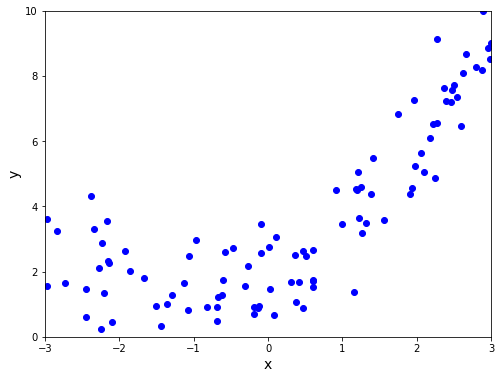

In [27]:
plt.figure(figsize=[8,6])
plt.scatter(X, y, c = "blue")
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

<br>

Vamos fitar uma regressão linear nos dados e ver os resultados:
    
<br>

In [28]:
lm = LinearRegression().fit(X, y)

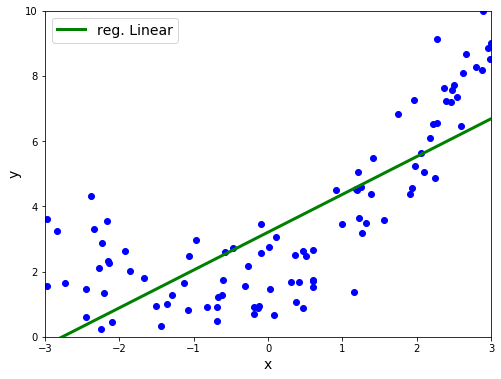

In [29]:
plt.figure(figsize=[8,6])
plt.scatter(X, y, c = "blue")
plt.plot(X, lm.predict(X), c = 'green', lw = 3, label = 'reg. Linear')
plt.legend(fontsize = 14)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

<br>

Evidentemente, os resultados não são satisfatórios. A regressão linear não descreve bem os dados, está sofrendo de underfitting.

Vamos, na sequência, trabalhar com regressões polinomiais e comparar:
    
<br>

In [30]:
#importando a função
from sklearn.preprocessing import PolynomialFeatures

In [31]:
#criando uma função polinomial de ordem 2
poly_features = PolynomialFeatures(degree = 2, include_bias = False)

In [32]:
X_poly = poly_features.fit_transform(X)
X_poly.shape

(100, 2)

In [33]:
X_poly[:10]

array([[-2.96835655,  8.81114062],
       [-2.96524186,  8.79265931],
       [-2.83933482,  8.0618222 ],
       [-2.72803641,  7.44218264],
       [-2.44856267,  5.99545913],
       [-2.44382921,  5.97230121],
       [-2.37567638,  5.64383824],
       [-2.33931176,  5.47237952],
       [-2.27721995,  5.1857307 ],
       [-2.24882899,  5.05723181]])

In [34]:
np.c_[ X[:10],  X[:10]**2 ]

array([[-2.96835655,  8.81114062],
       [-2.96524186,  8.79265931],
       [-2.83933482,  8.0618222 ],
       [-2.72803641,  7.44218264],
       [-2.44856267,  5.99545913],
       [-2.44382921,  5.97230121],
       [-2.37567638,  5.64383824],
       [-2.33931176,  5.47237952],
       [-2.27721995,  5.1857307 ],
       [-2.24882899,  5.05723181]])

In [35]:
poly_fit = LinearRegression() #também poderíamos ter usado nossa classe regLinear com gradient descent!
poly_fit.fit(X_poly, y)

poly_fit.intercept_, poly_fit.coef_

(array([1.73462505]), array([[1.02726783, 0.49469175]]))

<br>

Acima, modelamos y sendo:

### $y = \theta_0 + \theta_1 \cdot X + \theta_2 \cdot X^2$,

ou seja, um polinômio de grau(ordem) 2.

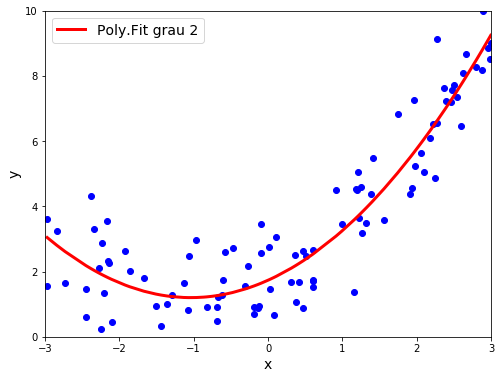

In [36]:
y_new = poly_fit.predict(X_poly)

plt.figure(figsize=[8,6])
plt.scatter(X, y, c = "blue")
plt.plot(X, y_new, "r-", linewidth=3, label="Poly.Fit grau 2")
plt.legend(fontsize = 14)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

<br>

__Comparando os resultados visualmente:__
    
<br>

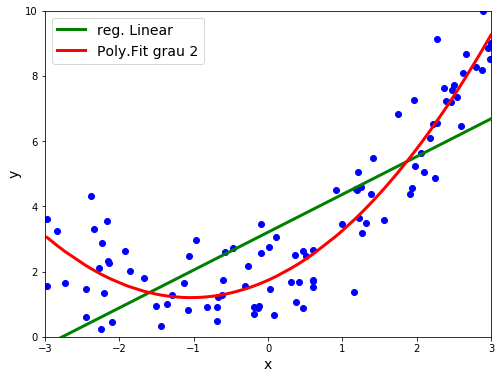

In [37]:
plt.figure(figsize=[8,6])
plt.plot(X, lm.predict(X), c = 'green', lw = 3, label = 'reg. Linear')
plt.scatter(X, y, c = "blue")
plt.plot(X, y_new, "r-", linewidth=3, label="Poly.Fit grau 2")
plt.legend(fontsize = 14)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.axis([-3, 3, 0, 10])
plt.show()

<br>

O polinômio de grau 2 fitou os dados muito melhor!

O que aconteceria se tivéssemos usado graus maiores? 

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [39]:
def polyFit(X, y, grau): 
    
    polybig_features = PolynomialFeatures(degree = grau, include_bias = False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    
    #criando um pipeline: sequencia de execução de passos
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    
    polynomial_regression.fit(X, y)
    return polynomial_regression

grau:  1


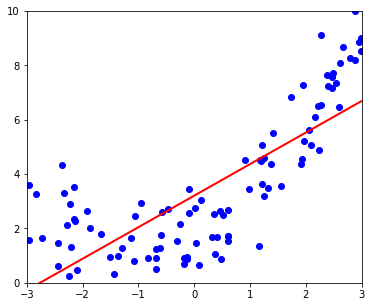

RMSE:
1.692595027434142
------------------------------------------------


grau:  2


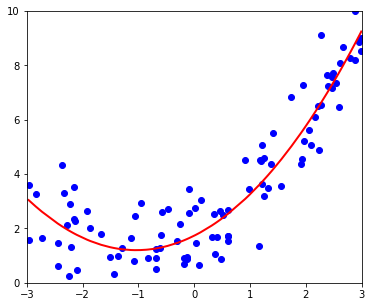

RMSE:
1.0023367286451514
------------------------------------------------


grau:  20


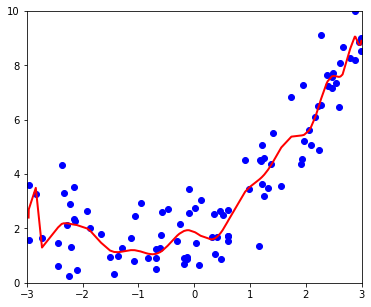

RMSE:
0.9526449866275867
------------------------------------------------


grau:  300


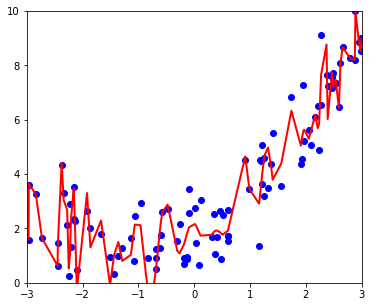

RMSE:
0.7722654459461707
------------------------------------------------




In [40]:
for grau in [1,2,20,300]:  
    
    print("grau: ", grau)
    
    polyfit = polyFit(X, y, grau)
    
    ypoly = polyfit.predict(X)
    
    plt.figure(figsize=[6,5])
    plt.plot(X, ypoly, label=str(grau), lw=2, c = 'red')
    plt.scatter(X, y, c = "blue")
    plt.axis([-3, 3, 0, 10])
    plt.show()
    print("RMSE:")
    print(np.sqrt(np.mean(np.square(y - polyfit.predict(X)))))
    print("------------------------------------------------\n\n")

Analisando apenas o erro nos dados de treino, vemos que o RMSE tende a diminuir a medida que usamos polinômios de graus mais altos.. mas e com dados novos? Será que estamos overfitando?

Vejamos:
<br>

In [41]:
Xnovo, ynovo = geraDados()

grau:  1


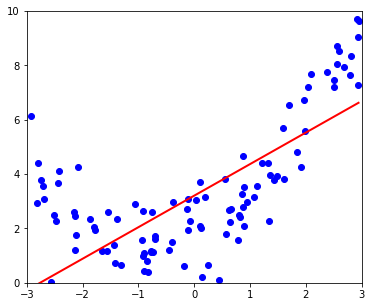

RMSE:
treino: 1.692595027434142
novos dados: 1.844842416020915
------------------------------------------------


grau:  2


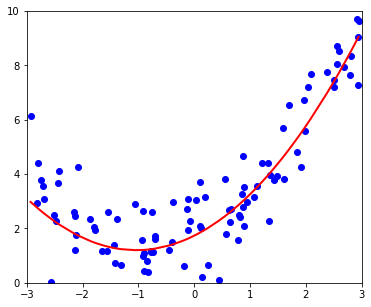

RMSE:
treino: 1.0023367286451514
novos dados: 1.0167477566632792
------------------------------------------------


grau:  20


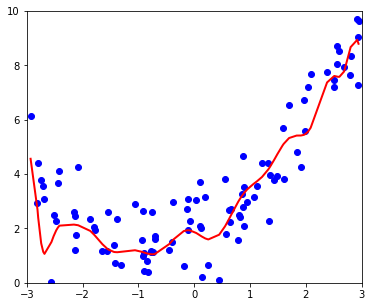

RMSE:
treino: 0.9526449866275867
novos dados: 1.0358940624619324
------------------------------------------------


grau:  300


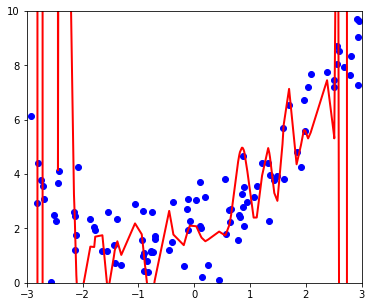

RMSE:
treino: 0.7722654459461707
novos dados: 38216445382.27082
------------------------------------------------




In [42]:
for grau in [1,2,20,300]:
    
    print("grau: ", grau)
    
    polyfit = polyFit(X, y, grau)
    
    ypoly_novo = polyfit.predict(Xnovo)
    
    plt.figure(figsize=[6,5])
    plt.plot(Xnovo, ypoly_novo, label=str(grau), lw=2, c = 'red')
    plt.scatter(Xnovo, ynovo, c = "blue")
    plt.axis([-3, 3, 0, 10])
    plt.show()
    print("RMSE:")
    print('treino:', np.sqrt(np.mean(np.square(y - polyfit.predict(X)))))
    print('novos dados:', np.sqrt(np.mean(np.square(ynovo - polyfit.predict(Xnovo)))))
    print("------------------------------------------------\n\n")

<br>

__Conclusão:__
    
Nitidamente, polinômios de ordens altas acabam __overfitando__ os dados!

No entanto, o __polinômio de grau 2 obteve o melhor resultado:__ obteve um baixo RMSE em treino e conseguiu generalizar bem os dados.

<br>

Como podemos controlar o overfitting de modelos polinomiais com graus altos?

Uma técnica muito comum para isso é a __regularização!__

<br><br>

## Regularização

<br>

Como vimos, modelos polinomiais nada mais são do que regressões lineares, porém utilizando potências das variávies explicativas originais.

Neste contexto, regularizar significa __restringir__ os possíveis valores de $\theta$. Tendo valores de $\theta$ menores, conseguiremos controlar o overfitting.

Existem dois tipos de regularizações mais famosos: a __Ridge__ e a __Lasso.__ 

No caso da regressão linear, vimos que os valores de $\theta$ são escolhidos ao minimizarmos o MSE:

#### $y_{pred} = \theta_0 + \theta_1 \cdot X_1 + .. + \theta_p \cdot X_p$.

#### $\theta = (\theta_0, \theta_1, .., \theta_p)$ 

#### $Custo(\theta) = MSE(\theta) = $ 1/N $\cdot \sum (y_{pred_i} - y_i)^{2}$, 

em que a soma é nas instâncias de treinamento.

<br>

### Regularização Ridge

Nesta regularização, é adicionado um __termo de regularização__ na função de custo MSE, conhecido como __norma L2__.

A função de custo é alterada para:

### $Custo(\theta) = MSE(\theta) + \alpha \cdot \sum {\theta_i}^2$, 
em que a soma $\sum {\theta_i}^2$ é para valores de $i=1, .., p$.

Ainda, veja que o parâmetro $\alpha$ é responsável pela quantidade de regularização. Caso $\alpha$ seja igual a zero, não existe regularização, ou seja:

Ridge($\alpha$=0) = LinearRegression;

Além disso, quanto maior o valor de $\alpha$, maior é a regularização.

Ao treinarmos um modelo com regularização, o objetivo é minimizar a função de custo. Desta forma, caso $\alpha$ seja muito grande, precisaremos de $\theta$ muito pequenos para compensar, logo temos essa restrição dos valores de $\theta$.


<br><br>


### Regularização Lasso

Análogo o caso da Ridge, mas o __termo de regularização__ neste caso é a __norma L1.__

Neste caso, a função de custo a ser minimizada é:

### $Custo(\theta) = MSE(\theta) + \alpha \cdot \sum |{\theta_i}|$, 
em que a soma $\sum |\theta_i|$ é para valores de $i=1, .., p$.

<br><br>

No python:

In [43]:
from sklearn.linear_model import Ridge, Lasso

In [44]:
def polyFitReg(X, y, grau, base_model, base_model_name):
    
    polybig_features = PolynomialFeatures(degree = grau, include_bias = False)
    std_scaler = StandardScaler()
    basemodel = base_model
    
    #criando um pipeline: sequencia de execução de passos
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            (base_model_name, base_model),
        ])
    
    polynomial_regression.fit(X, y)
    return polynomial_regression

Ridge_ alpha: 0


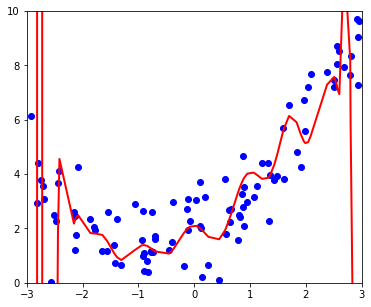

RMSE:
treino: 0.9014915570382815
novos dados: 2329.767431857671
------------------------------------------------


Ridge_ alpha: 0.001


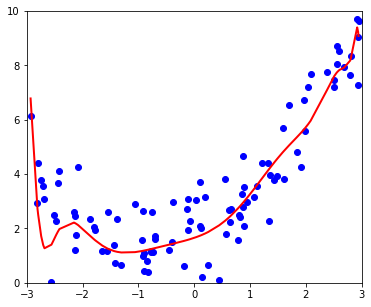

RMSE:
treino: 0.9619372583070128
novos dados: 1.0083651965820337
------------------------------------------------


Ridge_ alpha: 0.01


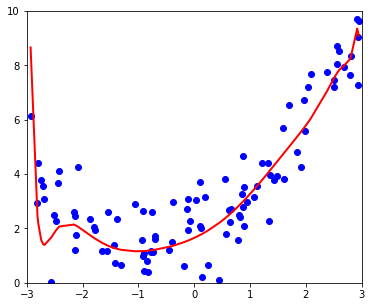

RMSE:
treino: 0.967872810384079
novos dados: 1.0403886959594655
------------------------------------------------


Ridge_ alpha: 0.1


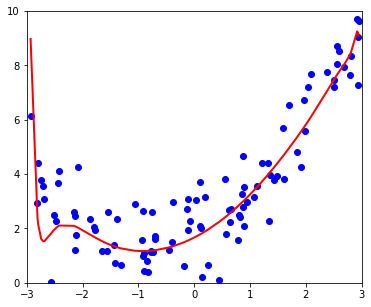

RMSE:
treino: 0.9720348151080724
novos dados: 1.0450730118413076
------------------------------------------------


Ridge_ alpha: 1


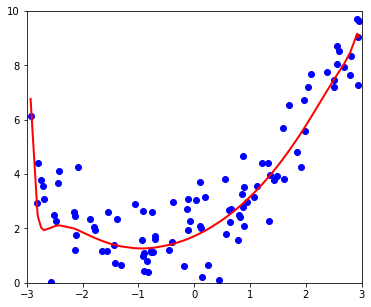

RMSE:
treino: 0.9790680174441356
novos dados: 0.9780003533065781
------------------------------------------------


Ridge_ alpha: 10


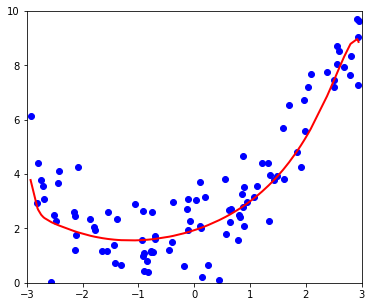

RMSE:
treino: 1.0308868639630002
novos dados: 1.0069701242862221
------------------------------------------------


Ridge_ alpha: 100


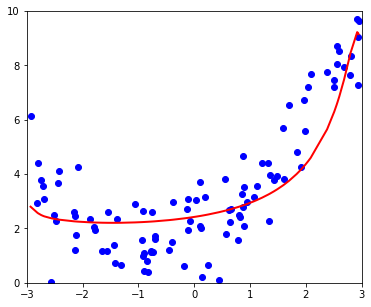

RMSE:
treino: 1.3087388197782492
novos dados: 1.2442866432670854
------------------------------------------------




In [45]:
grau = 200 

for alpha in [0, 0.001, 0.01, 0.1, 1, 10, 100]:
    
    model_name = 'Ridge_ alpha: '+str(alpha)
    polyfit = polyFitReg(X, 
                         y, 
                         grau, 
                         base_model = Ridge(alpha = alpha), 
                         base_model_name = model_name)
    
    ypoly_novo = polyfit.predict(Xnovo)

    print(model_name)
    plt.figure(figsize=[6,5])
    plt.plot(Xnovo, ypoly_novo, label=str(grau), lw=2, c = 'red')
    plt.scatter(Xnovo, ynovo, c = "blue")
    plt.axis([-3, 3, 0, 10])
    plt.show()
    print("RMSE:")
    print('treino:', np.sqrt(np.mean(np.square(y - polyfit.predict(X)))))
    print('novos dados:', np.sqrt(np.mean(np.square(ynovo - polyfit.predict(Xnovo)))))
    print("------------------------------------------------\n\n")

<br>

Veja que, mesmo usando polinômios de grau 200 (grau muito alto!!) conseguimos ter resultados satisfatórios, por exemplo ao usarmos $\alpha$ = 1.

No dia-a-dia, __é fundamental testar bem os dados para escolher os melhores parâmetros da regularização!__


<br><br>

Vamos agora discutir sobre a implementação da 

## Regressão Logística

<br>

Como vimos no módulo de classificação, a regressão logística calcula uma __combinação linear__ das variáveis de entrada. No entanto, o output não é diretamente essa combinação, como no caso da regressão linear, mas sim uma transformação dessa combinação, conhecida como a logística.

Esse output é usado para estimar a probabilidade de uma instância ser de uma classe. Desta forma, considere que estamos diante de um problema de classificação binária e temos k variáveis explicativas disponíveis. A estimativa da probabilidade feita pela regressão logística é dada por: 

$\hat p = \sigma ( \theta_0 + \theta_1 \cdot X_1 + \theta_2 \cdot X_2 + .. + \theta_k \cdot X_k)$

onde $\hat p $ representa a probabilidade estimada.

Ainda, $\sigma$ representa a função sigmoide, cuja expressão é:

$\sigma (t) $ = 1 / (1 + $\exp(-t))$

Dessa forma, a probabilidade estimada pode ser escrita como:

$\hat p  = 1 / (1 + \exp(-1 * (\theta_0 + \theta_1 \cdot X_1 + \theta_2 \cdot X_2 + .. + \theta_k \cdot X_k) ) )$


Aqui, $\hat p $ representa a probabilidade da instância ser da classe 1; desta forma, o valor  ($1 - \hat p $) representa a probabilidade da instância ser da classe 0.

Tendo os valores de $\theta_0, .. \theta_k$, podemos calcular essa probabilidade para cada instância.

Para a classificação binária, a regra segue:

$y_{pred} = 1$ se $\hat p$ > 0.5; 

$y_{pred} = 0$ caso contrário. 

Aqui 0.5 é o __limiar__ e pode ser alterado!

<br>
<br>

__A pergunta que fica é: Como descobrimos os valores ótimos de__ $\theta = (\theta_0, \theta_1, .., \theta_k)$ __?__

Metodologia para solução: Usaremos __gradient descent!!__

De forma similar a regressão linear, teremos uma __função de custo__ que queremos minimizar. A função de custo na regressão linear foi o __MSE__: o objetivo foi descobrir o conjunto de parâmetros $\theta$ que __minimize a função de custo MSE__.

Para minimizar a função de custo, usamos o procedimento de iterações do gradient descent.

No caso da regressão logística, faremos o mesmo. No entanto, a __função de custo da logística é diferente!__

Vamos começar por discutir a função de custo da  regressão logística: __log loss__ ou __perda logarítmica__.

Como o nome mostra, essa função usa a __função logaritmo:__

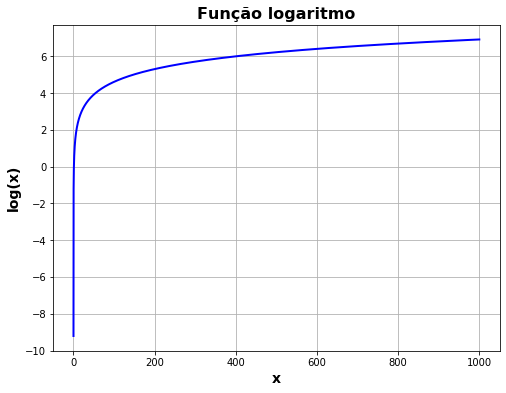

In [46]:
xlims = np.arange(0.0001, 1000, 0.1)
log_x = [np.log(x) for x in xlims]

plt.figure(figsize=[8,6])
plt.title("Função logaritmo", fontsize = 16, fontweight = 'bold')
plt.xlabel("x", fontsize = 14, fontweight = 'bold')
plt.ylabel("log(x)", fontsize = 14, fontweight = 'bold')
plt.plot(xlims, log_x, c = 'blue', lw = 2)
plt.grid()
plt.show()

A função logaritmo tem algumas propriedades importantes:
    
    1- Só está definida para valores positivos;
    
    2- Se x é muito próximo de 0, então log(x) tende a menos infinito;
    
    3- Quanto maior o valor de x, maior o valor de log(x);
    
    4- log(1) = 0.

Considere um problema de classificação binária, em que a variável target vale 0 (classe negativa) ou 1 (classe positiva).

Considere uma instância de treino cuja classe real seja 1. Ou seja, $y_{real} = 1$.

Assuma que calculamos $\hat p$, de acordo com uma certa metodologia. Sabemos que $\hat p$ é interpretado como a __probabilidade da instância ser da classe 1__. Portanto, se $\hat p$ está próximo de 1, significa que o __custo__, ou o __erro__,é baixo. Por outro lado, se $\hat p $ estiver próximo de 0, temos que o custo (ou o erro) é alto.

Analogamente, se $y_{real} = 0$, queremos que $\hat p$ seja próximo de 0, tendo assim um custo pequeno.

Portanto, __podemos medir o custo de uma predição:__

Considere uma instância x e com predição $\hat p$ 

$custo(x) = -log(\hat p) $ se  $ y_{real} = 1$

$custo(x) = -log(1 - \hat p) $ se $ y_{real} = 0$

Vamos analisar em detalhes esse custo!

Caso 1: $y_{real} = 1$

Se $\hat p$ próximo de 0: $custo(x) = -log(\hat p) \sim  -log(0) = $ infinito: custo muito alto!

Se $\hat p$ próximo de 1: $custo(x) = -log(\hat p) \sim  -log(1) = $ 0: custo mínimo!

Caso 2: $y_{real} = 0$

Se $\hat p$ próximo de 0: $custo(x) = -log(1 - \hat p) \sim  -log(1) = $ 0: custo mínimo!

Se $\hat p$ próximo de 1: $custo(x) = -log(1 - \hat p) \sim  -log(0) = $ 0: infinito: custo muito alto!


### Log Loss:

Considerando agora todo o dataset de treinamento, podemos escrever a __função de perda logarítmica como:__

### $Log Loss = $ -1/M $ \cdot \sum  [ y_i \cdot log(\hat p_i) + (1 - y_i) \cdot log(1 - \hat p_i) ]$

em que M é a quantidade de instâncias no dataset de treinamento e a soma é feita em cima dessas instâncias.

No caso da regressão logística, expressamos

$\hat p  = 1 / (1 + \exp(-1 * (\theta_0 + \theta_1 \cdot X_1 + \theta_2 \cdot X_2 + .. + \theta_k \cdot X_k) ) )$,

e se substituirmos esse valor na fórmula da Log Loss, vemos que a __Log Loss depende dos parâmetros__ $\theta$ __!__

Conclusão:

A regressão logística expressa a probabilidade de uma instância pertencer a classe positiva da forma

$\hat p  = 1 / (1 + \exp(-1 * (\theta_0 + \theta_1 \cdot X_1 + \theta_2 \cdot X_2 + .. + \theta_k \cdot X_k) ) )$

e o conjunto de parâmetros $\theta$ é justamente __o conjunto de parâmetros que minimiza a Log Loss.__

<br><br>

### Minimizando a Log Loss:

Vamos usar o __gradient descent__ para isso. A fórmula de atualização dos pesos é dada por:

$\theta_{next} = \theta - \alpha \cdot $ gradient_Log_Loss.

Neste caso, o gradient_Log_Loss é expresso por :

gradient_Log_loss = $ X^{T} \cdot ( \hat p - y ) $.

Vamos implementar em python esses resultados:

In [47]:
#gerando dados simulados para testar

from sklearn.datasets import make_blobs
def geraDados2(size):
    X, y = make_blobs(n_samples = size, n_features = 2, centers = [[0,0], [1,0]], cluster_std = 0.25)
    y = y.reshape(-1,1)
    return X, y

In [48]:
X, y = geraDados2(400)
X.shape, y.shape

((400, 2), (400, 1))

In [49]:
X[:10]

array([[ 0.30861623, -0.23051028],
       [ 0.97301981, -0.26599241],
       [ 0.28783372, -0.40139251],
       [-0.12142945, -0.00175883],
       [ 0.56407622, -0.03465923],
       [ 0.16331166, -0.04809245],
       [ 0.97512475,  0.42504054],
       [-0.05707482, -0.03554649],
       [ 1.0086661 , -0.34488628],
       [-0.07334421,  0.39872797]])

In [50]:
y

array([[1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
    

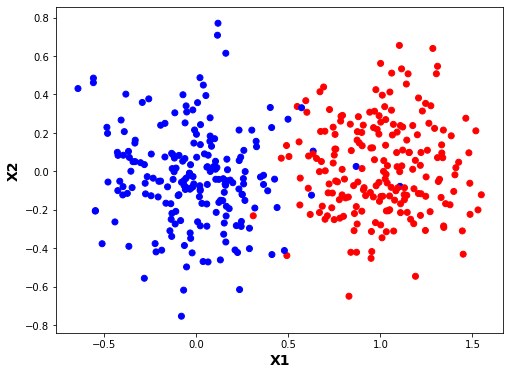

In [51]:
plt.figure(figsize=[8,6])
plt.scatter(X[:, 0], X[:, 1], c = y.reshape(-1,), cmap = plt.cm.bwr)
plt.xlabel("X1", fontsize = 14, fontweight = 'bold')
plt.ylabel("X2", fontsize = 14, fontweight = 'bold')
plt.show()

In [52]:
#implementando a função de perda logarítmica - Log Loss

def logLossCost(ytrue, ypred_probs):
    return (ytrue * np.log(ypred_probs) + (1 - ytrue) * np.log(1 - ypred_probs)).mean() * -1

In [53]:
def sigmoid(t):
    return 1 / (1 + np.exp(-t))

In [54]:
#implementação do gradient descent para treinamento da regressão logística


learning_rate = 0.01
num_steps = 100

#criando uma coluna de 1's no dataset X 
X_b = np.c_[np.ones(X.shape[0]), X]

#instanciando um vetor de parâmetros theta aleatório
theta = np.random.randn(X_b.shape[1],1)


for step in range(num_steps):
    
    print('passo:', step)
    print('theta:', theta.reshape(-1,))
    
    #calculando a probabilidade 
    yscores = sigmoid(X_b.dot(theta))
    
    #calculando o gradiente da Log Loss
    gradient = X_b.T.dot(yscores - y)
    
    #atualizando os pesos
    theta = theta - learning_rate * gradient
    
    #calculando a Log Loss dentro do passo
    logloss_step = logLossCost(ytrue = y, ypred_probs = yscores)
    print("Log Loss:", logloss_step)
    print('\n-----------------------------------------------------------\n')
    
theta_final = theta

passo: 0
theta: [-0.54534246 -1.00148686 -1.08766998]
Log Loss: 1.1296388119090826

-----------------------------------------------------------

passo: 1
theta: [ 0.33636203  0.70346822 -0.98441383]
Log Loss: 0.6086137748500542

-----------------------------------------------------------

passo: 2
theta: [-0.3007189   1.21118426 -0.88458724]
Log Loss: 0.46818731384707996

-----------------------------------------------------------

passo: 3
theta: [-0.57346947  1.73917936 -0.79712668]
Log Loss: 0.38709737041241704

-----------------------------------------------------------

passo: 4
theta: [-0.81355717  2.15170731 -0.72343145]
Log Loss: 0.3338030058599822

-----------------------------------------------------------

passo: 5
theta: [-1.00775117  2.49785176 -0.66040035]
Log Loss: 0.2964265508048685

-----------------------------------------------------------

passo: 6
theta: [-1.17193267  2.79461188 -0.60567629]
Log Loss: 0.26883502264056547

-------------------------------------------

In [55]:
#fazendo as predições com o theta final

probs = sigmoid(X_b.dot(theta_final))
probs

array([[1.66043570e-01],
       [9.80983368e-01],
       [1.37660901e-01],
       [5.73994735e-03],
       [6.41099705e-01],
       [5.83346171e-02],
       [9.84481804e-01],
       [9.71244126e-03],
       [9.85518707e-01],
       [9.54649328e-03],
       [9.91716303e-01],
       [1.81918059e-02],
       [9.94055184e-01],
       [9.84614093e-01],
       [6.65050834e-03],
       [9.90135658e-01],
       [5.56282980e-02],
       [2.09678798e-02],
       [2.59827997e-02],
       [8.95806776e-01],
       [2.71066571e-02],
       [7.64278767e-02],
       [5.59830665e-02],
       [1.10327729e-02],
       [9.85595563e-01],
       [9.23867694e-01],
       [1.34131746e-02],
       [9.30405731e-01],
       [7.33478112e-03],
       [7.69700806e-01],
       [1.01920199e-01],
       [9.94988672e-01],
       [9.49602940e-01],
       [9.41494166e-01],
       [8.87676288e-01],
       [1.03213954e-01],
       [9.99226824e-01],
       [1.08335670e-02],
       [4.36538129e-01],
       [9.88965779e-01],


In [56]:
limiar = 0.5
ypred = np.where(probs > limiar, 1, 0)
ypred

array([[0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
    

In [57]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_true = y, y_pred = ypred)

array([[194,   6],
       [  3, 197]])